In [306]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import datetime as dt
import random 
import matplotlib.pyplot as plt
import numpy as np

from data_preprocessing.DataLoader import DataLoader

In [307]:
d = DataLoader.load_data_from_path("data/data_new")

In [308]:
def unite_sets(deliveries, products, sessions, users):
    deliveries["deltas"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]

    # divide category
    categories = products.category_path.str.split(';', expand=True)
    products = pd.concat([products, categories], axis=1)
    products = products.drop(columns=['category_path'])
    products = products.rename(
        columns={0: "primary_category", 1: "secondary_category", 2: "tertiary_category", 3: "quaternary_category"})


    deliveries_sessions = pd.merge(deliveries, sessions, left_on="purchase_id", right_on="purchase_id")
    deliveries_sessions_users = pd.merge(deliveries_sessions, users, left_on="user_id", right_on="user_id")
    deliveries_sessions_users_products = pd.merge(deliveries_sessions_users, products, left_on="product_id", right_on="product_id")

    deliveries_sessions_users_products.to_csv('../out.csv')
    return deliveries_sessions_users_products

In [309]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [310]:
d = DataLoader.load_data_from_path("data/data_new")

products = d.products
deliveries = d.deliveries
sessions = d.sessions
users = d.users

united = unite_sets(deliveries, products, sessions, users)

In [311]:
# nie wnosi zadnej informacji wiec wyrzucamy daną kolumnę
united = united.loc[:, united.columns != 'event_type']
united = united.loc[:, united.columns != 'name']
united = united.loc[:, united.columns != 'street']
united = united.loc[:, united.columns != 'product_name']
united = united.loc[:, united.columns != 'delivery_timestamp']
united = united.loc[:, united.columns != 'timestamp']
united = united.loc[:, united.columns != 'purchase_id']
united = united.loc[:, united.columns != 'product_id']
united = united.loc[:, united.columns != 'user_id']
united = united.loc[:, united.columns != 'session_id']
united = united.loc[:, united.columns != 'offered_discount']
united = united.loc[:, united.columns != 'price']
united = united.loc[:, united.columns != 'primary_category']
united = united.loc[:, united.columns != 'secondary_category']
united = united.loc[:, united.columns != 'tertiary_category']
united = united.loc[:, united.columns != 'quaternary_category']

united.loc[:,'time_of_day'] = united.apply(lambda row: labelTimeOfDay(row), axis=1)
united['weekday'] = united['purchase_timestamp'].dt.day_name()
united = united.loc[:, united.columns != 'purchase_timestamp']

In [312]:
y = pd.get_dummies(united.city, prefix='city')
united = united.join(other=y)
united = united.loc[:, united.columns != 'city']

y = pd.get_dummies(united.delivery_company, prefix='delivery_company')
united = united.join(other=y)
united = united.loc[:, united.columns != 'delivery_company']

y = pd.get_dummies(united.time_of_day, prefix='time_of_day')
united = united.join(other=y)
united = united.loc[:, united.columns != 'time_of_day']

y = pd.get_dummies(united.weekday, prefix='weekday')
united = united.join(other=y)
united = united.loc[:, united.columns != 'weekday']

united['deltas'] = pd.to_numeric(united['deltas'].dt.days, downcast='integer')

In [313]:
#checking data distribution

united_0 = united.loc[united['deltas'] == 0]
united_1 = united.loc[united['deltas'] == 1]
united_2 = united.loc[united['deltas'] == 2]
united_3 = united.loc[united['deltas'] == 3]
united_4 = united.loc[united['deltas'] == 4]
united_3_4 = united.loc[united['deltas'].isin([3,4])]

sizes = [len(united_0), len(united_1), len(united_2),len(united_3_4)]
print(len(united_0))
print(len(united_1))
print(len(united_2))
print(len(united_3))
print(len(united_4))

# #merging groups
# united.loc[united['deltas'].isin([3,4]),'deltas'] = 3
# print("AFTER MERGE:")
# print(len(united.loc[united['deltas'].isin([3,4])]))


1150
3480
2134
659
70


In [314]:
target_column = ['deltas'] 
predictors = list(set(list(united.columns))-set(target_column))
# united[predictors] = united[predictors]/united[predictors].max()
# united.describe().transpose()

In [315]:
train, test= train_test_split(united, test_size=0.30, random_state=40)

In [316]:
# column_names = united.columns

# train_united_0 = train.loc[train['deltas'] == 0]
# train_united_1 = train.loc[train['deltas'] == 1]
# train_united_2 = train.loc[train['deltas'] == 2]
# train_united_3 = train.loc[train['deltas'] == 3]
# train_united_4 = train.loc[train['deltas'] == 4]
# train_united_3_4 = train.loc[train['deltas'].isin([3,4])]



# print(len(train_united_0))
# print(len(train_united_1))
# print(len(train_united_2))
# print(len(train_united_3))
# print(len(train_united_4))
# print(len(train_united_3_4))


# # sizes = [len(train_united_0), len(train_united_1), len(train_united_2),len(train_united_3),len(train_united_4)]

# sizes = [len(train_united_0), len(train_united_1), len(train_united_2),len(train_united_3_4)]

# united_divided = [train_united_0, train_united_1, train_united_2, train_united_3_4]
# new_united = []

# for df in united_divided:
#     new_size = random.randint(1000, 1200)
#     if(len(df) < new_size):
#         new_united += df.values.tolist()
#         new_united += df.sample(new_size - len(df), replace=True).values.tolist()
#     else:
#         new_united += df.sample(new_size).values.tolist()

# new_united = pd.DataFrame.from_records(new_united, columns = column_names)

# train_united_0 = new_united.loc[new_united['deltas'] == 0]
# train_united_1 = new_united.loc[new_united['deltas'] == 1]
# train_united_2 = new_united.loc[new_united['deltas'] == 2]
# train_united_3 = new_united.loc[new_united['deltas'] == 3]
# train_united_4 = new_united.loc[new_united['deltas'] == 4]

# print("NEW:")
# print(len(train_united_0))
# print(len(train_united_1))
# print(len(train_united_2))
# print(len(train_united_3))
# print(len(train_united_4))

# train = new_united
# train.describe().transpose()

In [317]:
X_train = train[predictors].values
y_train = train[target_column].values

X_test = test[predictors].values
y_test = test[target_column].values

#Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [318]:
sizePred = len(predictors)
mlpClassifier = MLPClassifier(activation='relu', solver='sgd', max_iter=1000)
mlpClassifier.fit(X_train,y_train.ravel())

predict_train = mlpClassifier.predict(X_train)
predict_test = mlpClassifier.predict(X_test)

In [319]:
from sklearn.metrics import classification_report,confusion_matrix

#Evaluate predictions for train data
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))


[[ 542  241   40    0    0]
 [ 209 1958  235   24    0]
 [  37  352 1031   65    2]
 [   1   44  128  285    4]
 [   0    0   17   10   20]]
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       823
           1       0.75      0.81      0.78      2426
           2       0.71      0.69      0.70      1487
           3       0.74      0.62      0.67       462
           4       0.77      0.43      0.55        47

    accuracy                           0.73      5245
   macro avg       0.73      0.64      0.68      5245
weighted avg       0.73      0.73      0.73      5245



In [320]:
#Evaluate predictions for test data
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[202 107  17   1   0]
 [118 818 107  11   0]
 [ 18 179 415  33   2]
 [  1  29  62 102   3]
 [  0   0  10   4   9]]
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       327
           1       0.72      0.78      0.75      1054
           2       0.68      0.64      0.66       647
           3       0.68      0.52      0.59       197
           4       0.64      0.39      0.49        23

    accuracy                           0.69      2248
   macro avg       0.66      0.59      0.62      2248
weighted avg       0.69      0.69      0.69      2248



<function matplotlib.pyplot.show(close=None, block=None)>

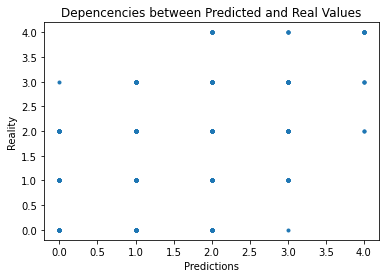

In [322]:
plt.plot(predict_test, y_test,".")
plt.title("Depencencies between Predicted and Real Values")
plt.xlabel("Predictions")
plt.ylabel("Reality")
plt.show

In [ ]:
import pickle
f = open('models/neural_n_1.0.0.pickle', 'wb')
pickle.dump(mlpClassifier, f)
f.close()